In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import argparse
import subprocess
import pdb
import time
import random
import _pickle as cPickle
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats

from data_structure import get_batches
from hntm import HierarchicalNeuralTopicModel
from gsm import GaussianSoftmaxModel
from rsm import RecurrentStickbreakingModel
from tree import get_descendant_idxs
from evaluation import validate, get_topic_specialization, get_hierarchical_affinity, print_topic_sample
from coherence import compute_word_count, compute_coherence
from configure import get_config
from ncrp import get_docs, get_freq_tokens_ncrp, get_perplexity as get_perplexity_ncrp, get_topic_specialization as get_topic_specialization_ncrp, get_hierarchical_affinities as get_hierarchical_affinity_ncrp
from rcrp import get_docs, get_freq_tokens_rcrp, get_perplexity as get_perplexity_rcrp, get_topic_specialization as get_topic_specialization_rcrp, get_hierarchical_affinities as get_hierarchical_affinity_rcrp

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '9'

# tools

In [14]:
def load_model(config, name_model, nb_name, index=-1):
    dir_model = os.path.join('model', config.data, name_model, ''.join(nb_name.split()[1:]))
    ckpt = cPickle.load(open(os.path.join(dir_model, 'checkpoint'), 'rb'))
    path_restore = ckpt[index]
    print('loading %s...' % path_restore)
    
    if name_model == 'hntm' or name_model == 'gsm' or name_model == 'rsm':
        path_config = path_restore + '.config'
        config = cPickle.load(open(path_config, 'rb'))
        if name_model == 'hntm':
            model = HierarchicalNeuralTopicModel(config)
        elif name_model == 'gsm':
            model = GaussianSoftmaxModel(config)
        elif name_model == 'rsm':
            model = RecurrentStickbreakingModel(config)
        sess = tf.Session()
        saver = tf.train.Saver()
        saver.restore(sess, path_restore)         
        return sess, model, config
    elif name_model == 'ncrp' or name_model == 'rcrp':
        test_docs, topic_root = cPickle.load(open(path_restore, 'rb'))
        config = get_config(nb_name)
        return test_docs, topic_root, config

In [4]:
def load_config(config, name_model, nb_name, index=-1):
    dir_model = os.path.join('model', config.data, name_model, ''.join(nb_name.split()[1:]))
    ckpt = cPickle.load(open(os.path.join
                             (dir_model, 'checkpoint'), 'rb'))
    path_restore = ckpt[index]
    
    if name_model == 'hntm' or name_model == 'gsm' or name_model == 'rsm':
        path_config = path_restore + '.config'
        config = cPickle.load(open(path_config, 'rb'))
    elif name_model == 'ncrp' or name_model == 'rcrp':
        config = get_config(nb_name)
    return config

## freq tokens 

In [5]:
def get_tree_freq_tokens(sess, model, bow_idxs, idx_to_word, topic_freq_tokens=None, parent_idx=0, depth=0):
    if depth == 0:
        topics_freq_indices = np.argsort(sess.run(model.topic_bow), 1)[:, ::-1][:, :10]
        topics_freq_idxs = bow_idxs[topics_freq_indices]
        topic_freq_tokens = {topic_idx: [idx_to_word[idx] for idx in topic_freq_idxs] for topic_idx, topic_freq_idxs in zip(model.topic_idxs, topics_freq_idxs)}
        
        # print root
        freq_tokens = topic_freq_tokens[parent_idx]
        print(parent_idx, ' '.join(freq_tokens))
    
    child_idxs = model.tree_idxs[parent_idx]
    depth += 1
    for child_idx in child_idxs:
        freq_tokens = topic_freq_tokens[child_idx]
        print('  '*depth, child_idx, ' '.join(freq_tokens))
        
        if child_idx in model.tree_idxs: 
            get_tree_freq_tokens(sess, model, bow_idxs, idx_to_word, topic_freq_tokens=topic_freq_tokens, parent_idx=child_idx, depth=depth)
            
    return topic_freq_tokens

def get_flat_freq_tokens(sess, model, bow_idxs, idx_to_word):
    topics_freq_indices = np.argsort(sess.run(model.topic_bow), 1)[:, ::-1][:, :10]
    topics_freq_idxs = bow_idxs[topics_freq_indices]
    topic_freq_tokens = {topic_idx: [idx_to_word[idx] for idx in topic_freq_idxs] for topic_idx, topic_freq_idxs in enumerate(topics_freq_idxs)}
    return topic_freq_tokens

## perplexity

In [6]:
def compute_perplexity(sess, model, batches, verbose=False):
    ppl_list = []
    for ct, batch in batches:
        feed_dict = model.get_feed_dict(batch, mode='test')
        ppls_batch = sess.run(model.topic_ppls, feed_dict = feed_dict)
        ppl_list += list(ppls_batch)
    ppl_mean = np.exp(np.mean(ppl_list))
    if verbose: print('Perplexity= %.1f' % ppl_mean)
    return ppl_mean

# bags

## load data

In [13]:
nb_name_base = '0 bags'
config_bags = get_config(nb_name_base)
instances_train_bags, instances_dev_bags, instances_bags, word_to_idx_bags, idx_to_word_bags, bow_idxs_bags = cPickle.load(open(config_bags.path_data,'rb'))
len(instances_train_bags), len(instances_dev_bags), len(instances_bags)
batches_bags = get_batches(instances_bags, config_bags.batch_size)

## restore hntm

In [15]:
if 'sess' in globals(): sess.close()
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '1  bags -tree 33 -temp 1 -seed 0', index=-1)
sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '2 bags -tree 33 -temp 10 -seed 0', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '3 bags -tree 33 -temp 10 -seed 0 -min', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '5 bags -tree 32 -temp 1 -seed 0', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '6 bags -tree 32 -temp 10 -seed 0', index=-1)

# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '1 bags -tree 33 -temp 1 -seed 0 -cell gru2', index=-1)

log_bags_hntm = cPickle.load(open(model_bags_hntm.config.path_log, 'rb'))
display(log_bags_hntm[-10:])
freq_tokens_bags_hntm = get_tree_freq_tokens(sess, model_bags_hntm, bow_idxs_bags, idx_to_word_bags)
coherence_bags_hntm = compute_coherence(freq_tokens_bags_hntm.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_hntm = compute_perplexity(sess, model_bags_hntm, batches_bags, verbose=True)
depth_specs_bags_hntm = get_topic_specialization(sess, model_bags_hntm, instances_bags, verbose=True)
hierarchical_affinities_bags_hntm = get_hierarchical_affinity(sess, model_bags_hntm, verbose=True)

loading model/bags/hntm/bags-tree33-temp10-seed0/model-465000...
INFO:tensorflow:Restoring parameters from model/bags/hntm/bags-tree33-temp10-seed0/model-465000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
450000   51  901  400  109.79  413  107.52  2.27  0.01  103.06  404  100.78   
455000   59  911  410  109.79  412  107.52  2.27  0.01  103.03  402  100.72   
460000   53  921  420  109.79  412  107.51  2.27  0.01  103.04  403  100.75   
465000   57  931  430  109.78  412  107.51  2.27  0.01  103.00  401  100.68   
470000   52  941  440  109.78  412  107.51  2.27  0.01  103.03  403  100.74   
475000   55  951  450  109.78  412  107.50  2.28  0.01  102.99  402  100.69   
480000   68  961  460  109.78  412  107.50  2.28  0.01  103.01  403  100.72   
485000   63  971  470  109.78  412  107.50  2.28  0.00  103.00  402  100.68   
490000   54  981  480  109.77  412  107.49  2.28  0.00  103.03  404  100.75   
495000   57  991  490  109.77  412  107.49  2.28  0.00  103.00  402  100.69   

                     TEST:      SPEC:             HIER:        
          KL   REG    LOSS  PPL     1     2     3 CHILD OTHER  
450000  2.28  0.00  101.08  397  0.33  0.62  0.61  0.24  0.05  
455000  2.31  0.00  101.08  397  0.33  0.62  0.64  0.23  0.06  
460000  2.29  0.00  101.08  397  0.33  0.62  0.61  0.24  0.05  
465000  2.32  0.00  101.07  396  0.33  0.62  0.64  0.23  0.06  
470000  2.29  0.00  101.07  396  0.33  0.62  0.61  0.24  0.05  
475000  2.30  0.00  101.07  396  0.33  0.61  0.64  0.23  0.06  
480000  2.28  0.00  101.07  396  0.33  0.61  0.61  0.23  0.05  
485000  2.32  0.00  101.07  396  0.33  0.61  0.64  0.21  0.06  
490000  2.29  0.00  101.07  396  0.33  0.62  0.62  0.23  0.05  
495000  2.32  0.00  101.07  396  0.33  0.61  0.64  0.22  0.06

0 refund provided build abuse acer tripod accessories mcover careful older
   1 priced sort junk older kindle slightly print cheap iphone surface
     11 cheap print sleeve constructed surprise sd surface completely beautiful pc
     14 sd priced notice cheap protecting classy cracks plug cracking carry
     12 notice office protecting cracking early wearing classy air afraid snapped
   4 snapped quickly appears pulls putting offers spacious junk spot iphone
     42 add / plastic plane manufacturer junk including disappointing % bother
   5 mba pulls plastic appears putting review read bring manufacturer daily
     52 % manufacturer plane review addition acer careful house battery marks
   2 daily bucks leave type holds shape prefer stitching everyday set
     21 complain daily leave manufacturer poorly ports breaking plastic received pads
Average Topic Coherence = 0.014


ValueError: Cannot feed value of shape (64, 1016) for Tensor 'Placeholder:0', which has shape '(?, 1035)'

## restore rsm

In [58]:
if 'sess' in globals(): sess.close()
sess, model_bags_rsm, config_bags_rsm = load_model(config=config_bags, name_model = 'rsm', nb_name = '1  bags -m rsm -seed 0 -static', index=-1)
log_bags_rsm = cPickle.load(open(model_bags_rsm.config.path_log, 'rb'))
display(log_bags_rsm[-10:])
freq_tokens_bags_rsm = get_flat_freq_tokens(sess, model_bags_rsm, bow_idxs_bags, idx_to_word_bags)
coherence_bags_rsm = compute_coherence(freq_tokens_bags_rsm.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_rsm = compute_perplexity(sess, model_bags_rsm, batches_bags, verbose=True)

loading model/bags/rsm/bags-mrsm-seed0-static/model-470000...
INFO:tensorflow:Restoring parameters from model/bags/rsm/bags-mrsm-seed0-static/model-470000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
450000   37  901  400  110.36  436  108.50  1.84  0.00  103.30  423  101.44   
455000   37  911  410  110.36  436  108.50  1.84  0.00  103.22  421  101.35   
460000   37  921  420  110.36  436  108.49  1.85  0.00  103.24  421  101.38   
465000   37  931  430  110.36  436  108.49  1.85  0.00  103.18  418  101.31   
470000   37  941  440  110.35  436  108.48  1.85  0.00  103.17  417  101.31   
475000   37  951  450  110.35  436  108.48  1.85  0.00  103.17  419  101.30   
480000   37  961  460  110.35  436  108.47  1.86  0.00  103.21  419  101.34   
485000   37  971  470  110.35  436  108.47  1.86  0.00  103.25  419  101.37   
490000   38  981  480  110.34  436  108.47  1.86  0.00  103.23  420  101.36   
495000   37  991  490  110.34  435  108.46  1.86  0.00  103.14  418  101.27   

                     TEST:       
          KL   REG    LOSS  PPL  
450000  1.86  0.00  101.67  422  
455000  1.87  0.00  101.67  422  
460000  1.85  0.00  101.67  422  
465000  1.86  0.00  101.67  422  
470000  1.86  0.00  101.55  420  
475000  1.87  0.00  101.55  420  
480000  1.87  0.00  101.55  420  
485000  1.88  0.00  101.55  420  
490000  1.87  0.00  101.55  420  
495000  1.87  0.00  101.55  420

Average Topic Coherence = 0.102
Perplexity= 472.0


## restore ncrp

In [59]:
# docs_bags, topic_bags, config_bags_ncrp = load_model(config=config_bags, name_model = 'ncrp', nb_name = '0 bags -m ncrp -alp 1 0.5 0.1 -eta 5 -gam 0.01 -epoch 30', index=-1)
docs_bags, topic_bags, config_bags_ncrp = load_model(config=config_bags, name_model = 'ncrp', nb_name = '0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 30', index=-1)
log_bags_ncrp = cPickle.load(open(config_bags_ncrp.path_log, 'rb'))
display(log_bags_ncrp[-10:])
freq_tokens_bags_ncrp = get_freq_tokens_ncrp(topic_bags, idx_to_word_bags, bow_idxs_bags)
coherence_bags_ncrp = compute_coherence(freq_tokens_bags_ncrp.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_ncrp = get_perplexity_ncrp(docs_bags, topic_bags, verbose=True)
depth_specs_bags_ncrp = get_topic_specialization_ncrp(docs_bags, topic_bags, verbose=True)
hierarchical_affinities_bags_ncrp = get_hierarchical_affinity_ncrp(topic_bags, verbose=True)

loading model/bags/ncrp/bags-mncrp-alp1051-eta5-gam0.01-epoch30/model-23...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
20  252  20  0    326    325   321  0.09  0.51  0.57  0.45  0.38
21  247  21  0    328    327   321  0.09  0.52  0.58  0.41  0.34
22  259  22  0    322    320   317  0.09  0.55  0.58  0.48  0.39
23  275  23  0    316    317   311  0.10  0.56  0.58  0.52  0.42
24  269  24  0    319    319   311  0.10  0.55  0.57  0.51  0.41
25  271  25  0    320    322   311  0.10  0.56  0.56  0.49  0.41
26  276  26  0    319    319   311  0.10  0.55  0.56  0.47  0.38
27  273  27  0    322    324   311  0.10  0.55  0.56  0.43  0.36
28  274  28  0    325    326   311  0.10  0.54  0.56  0.42  0.35
29  275  29  0    323    321   311  0.10  0.54  0.56  0.41  0.35

 0 31943 293236.0 ! nice bought price quality love perfect 'm recommend made
   0-1 5449 38040.0 ! cover color love keyboard mac pro perfectly apple easy
     0-1-2 5449 4398.0 picture true bottom protecting clear received blue light legs rubber
   0-2 1366 11201.0 carry work travel back handle pack trip pockets room wheels
     0-2-1 1346 1849.0 camera lenses canon lens equipment gear tripod accessories flash carry
     0-2-2 20 27.0 ripped room expecting makes flimsy compliments clip option short finding
   0-3 2834 24082.0 pocket power mouse room netbook sleeve cord charger ipad carry
     0-3-1 2834 2566.0 chromebook charger traveling sony dvd player ample perfect flash perfectly
   0-4 5292 37048.0 sleeve & ; protection air pro inch inside protect zipper
     0-4-1 4 10.0 trouble daily dvd stitching pieces nylon damaged absolutely box lots
     0-4-2 5288 5209.0 smell smells chemical sleeve thin mba corners corner edges padding
   0-5 2355 19465.0 zipper strap handle months broke 

## restore rcrp

In [22]:
# docs_bags, topic_bags, config_bags_rcrp = load_model(config=config_bags, name_model = 'rcrp', nb_name = '0 bags -m rcrp -alp 1 -eta 0.5 -gam 0.1 -epoch 30', index=-1)
# log_bags_rcrp = cPickle.load(open(config_bags_rcrp.path_log, 'rb'))
# display(log_bags_rcrp[-10:])
# freq_tokens_bags_rcrp = get_freq_tokens_rcrp(topic_bags, idx_to_word_bags, bow_idxs_bags)
# coherence_bags_rcrp = compute_coherence(freq_tokens_bags_rcrp.values(), config_bags.dir_corpus, topns=[5, 10])
# ppl_bags_rcrp = get_perplexity_rcrp(docs_bags, topic_bags, verbose=True)
# depth_specs_bags_rcrp = get_topic_specialization_rcrp(docs_bags, topic_bags, verbose=True)
# hierarchical_affinities_bags_rcrp = get_hierarchical_affinity_rcrp(topic_bags, verbose=True)

loading model/bags/rcrp/bags-mrcrp-alp1-eta0.5-gam0.1-epoch30/model-28...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
20  535  20  0      0    285   285  0.05  0.58  0.76  0.41  0.15
21  497  21  0      0    285   285  0.05  0.58  0.81  0.52  0.12
22  534  22  0      0    281   282  0.05  0.58  0.77  0.46  0.15
23  536  23  0      0    278   280  0.05  0.59  0.77  0.50  0.14
24  531  24  0      0    277   279  0.05  0.59  0.75  0.51  0.15
25  537  25  0      0    276   279  0.05  0.59  0.76  0.54  0.15
26  539  26  0      0    275   277  0.05  0.59  0.72  0.44  0.17
27  585  27  0      0    273   275  0.05  0.60  0.75  0.45  0.17
28  598  28  0      0    270   274  0.05  0.59  0.76  0.48  0.16
29  616  29  0      0    270   274  0.05  0.60  0.77  0.45  0.14

   0 : ['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18'] 883 5772.0 ['!', 'love', 'cover', 'nice', 'sleeve', ';', 'carry', '&', 'bought', 'price']
     0-1 : ['0-1-1'] 10312 57092.0 ['months', 'zipper', 'quality', 'strap', 'bought', 'broke', 'handle', 'years', "'ve", 'time']
       0-1-1 : [] 44 284.0 ['school', 'year', 'high', 'son', 'bought', 'swiss', 'chromebook', 'back', 'zipper', 'books']
     0-2 : ['0-2-1'] 11473 68875.0 ['pocket', 'room', 'mouse', 'power', 'sleeve', 'charger', 'small', 'netbook', 'carry', 'inch']
       0-2-1 : [] 440 2240.0 ['netbook', 'inch', 'sleeve', 'acer', 'battery', 'hp', 'aspire', 'small', 'laptops', 'bought']
     0-3 : [] 15342 71681.0 ['!', 'love', 'price', 'quality', 'bought', 'perfect', 'buy', 'recommend', 'color', '...']
     0-4 : [] 13338 72292.0 ['sleeve', '&', ';', 'protection', 'pro', 'air', 'inside', 'nice', 'protect', 'smell']
     0-5 : [] 2312 16527.0 ['

# 20news

## load data

In [16]:
nb_name_base = '0 20news'
config_20news = get_config(nb_name_base)
instances_train_20news, instances_dev_20news, instances_20news, word_to_idx_20news, idx_to_word_20news, bow_idxs_20news = cPickle.load(open(config_20news.path_data,'rb'))
len(instances_train_20news), len(instances_dev_20news), len(instances_20news)
batches_20news = get_batches(instances_20news, config_20news.batch_size)

## restore hntm

In [85]:
if 'sess' in globals(): sess.close()
sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '1 20news -tree 33 -temp 1 -seed 0', index=-1)
# sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '2 20news -tree 33 -temp 10 -seed 0', index=-1)
# sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '3 20news -tree 33 -temp 1 -seed 0 -min', index=-1)
log_20news_hntm = cPickle.load(open(model_20news_hntm.config.path_log, 'rb'))
display(log_20news_hntm[-10:])
freq_tokens_20news_hntm = get_tree_freq_tokens(sess, model_20news_hntm, bow_idxs_20news, idx_to_word_20news)
coherence_20news_hntm = compute_coherence(freq_tokens_20news_hntm.values(), config_20news.dir_corpus, topns=[5, 10], window_size = 0)
ppl_20news_hntm = compute_perplexity(sess, model_20news_hntm, batches_20news, verbose=True)
depth_specs_20news_hntm = get_topic_specialization(sess, model_20news_hntm, instances_20news, verbose=True)
hierarchical_affinities_20news_hntm = get_hierarchical_affinity(sess, model_20news_hntm, verbose=True)

loading model/20news/hntm/20news-tree33-temp1-seed0/model-170000...
INFO:tensorflow:Restoring parameters from model/20news/hntm/20news-tree33-temp1-seed0/model-170000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
130000   60  742  149  590.12  791  585.52  4.50  0.06  566.38  818  562.00   
135000   71  771   74  590.06  790  585.46  4.51  0.06  566.06  814  561.51   
140000   60  799  174  590.09  790  585.49  4.51  0.06  566.23  818  561.85   
145000   70  828   99  589.96  789  585.36  4.52  0.06  566.12  815  561.61   
150000   66  857   24  589.98  789  585.39  4.52  0.06  566.23  815  561.76   
155000   64  885  124  589.86  788  585.27  4.52  0.06  566.02  814  561.55   
160000   60  914   49  589.88  788  585.29  4.53  0.06  566.19  816  561.76   
165000   70  942  149  589.81  788  585.22  4.53  0.06  566.13  816  561.62   
170000   62  971   74  589.77  787  585.18  4.53  0.06  566.13  814  561.72   
175000   70  999  174  589.78  787  585.19  4.54  0.06  565.91  814  561.38   

                     TEST:      SPEC:             HIER:        
          KL   REG    LOSS  PPL     1     2     3 CHILD OTHER  
130000  4.37  0.02  566.11  817  0.11  0.46  0.47  0.35  0.26  
135000  4.46  0.09  566.04  815  0.11  0.47  0.48  0.36  0.28  
140000  4.36  0.01  566.04  815  0.12  0.44  0.48  0.37  0.27  
145000  4.42  0.09  566.04  815  0.12  0.46  0.48  0.36  0.28  
150000  4.41  0.06  566.04  815  0.13  0.47  0.46  0.38  0.29  
155000  4.43  0.04  566.04  815  0.12  0.43  0.48  0.37  0.27  
160000  4.42  0.01  566.04  815  0.13  0.46  0.48  0.34  0.26  
165000  4.44  0.08  566.04  815  0.11  0.46  0.47  0.37  0.28  
170000  4.40  0.01  566.20  815  0.11  0.47  0.47  0.35  0.26  
175000  4.46  0.08  566.20  815  0.12  0.45  0.47  0.37  0.29

0 write get article like one think know go make good
   1 god one say people jesus christian believe think write make
     11 say go people one come see know kill woman tell
     14 game team play player win year season hockey go score
     12 people gun israel state government law write article israeli right
   2 space launch use nasa year system satellite research program new
     23 people president say go turkish work government make armenian tax
   4 available include send software list use information image mail version
     41 key use chip one system clipper phone encryption number know
     42 file use encryption information government privacy law new device technology
   5 window use file program windows run application display server set
     51 drive use card system disk mac work one monitor driver
Average Topic Coherence = 0.220
Perplexity= 885.7
Topic Specialization: depth 1: 0.11 depth 2: 0.47 depth 3: 0.47 
Hierarchical Affinity: child 0.35, non-child 0.26


## restore rsm

In [86]:
if 'sess' in globals(): sess.close()
# sess, model_20news_rsm, config_20news_rsm = load_model(config=config_20news, name_model = 'rsm', nb_name = '1  20news -m rsm -seed 0 -static', index=-1)
# sess, model_20news_rsm, config_20news_rsm = load_model(config=config_20news, name_model = 'rsm', nb_name = '1 20news -m rsm -seed 0 -static -tmp', index=-1)
sess, model_20news_rsm, config_20news_rsm = load_model(config=config_20news, name_model = 'rsm', nb_name = '3 20news -m rsm -seed 0', index=-1)
log_20news_rsm = cPickle.load(open(model_20news_rsm.config.path_log, 'rb'))
display(log_20news_rsm[-10:])
freq_tokens_20news_rsm = get_flat_freq_tokens(sess, model_20news_rsm, bow_idxs_20news, idx_to_word_20news)
coherence_20news_rsm = compute_coherence(freq_tokens_20news_rsm.values(), config_20news.dir_corpus, topns=[5, 10], window_size = 0)
ppl_20news_rsm = compute_perplexity(sess, model_20news_rsm, batches_20news, verbose=True)

loading model/20news/rsm/20news-mrsm-seed0/model-170000...
INFO:tensorflow:Restoring parameters from model/20news/rsm/20news-mrsm-seed0/model-170000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
125000   45  721   12  595.23  898  590.30  4.83  0.05  570.70  932  565.94   
130000   45  749  112  595.11  897  590.15  4.84  0.05  571.54  942  566.83   
135000   46  778   37  595.11  897  590.13  4.85  0.05  570.67  929  565.90   
140000   46  806  137  595.03  897  590.02  4.85  0.05  572.61  944  567.91   
145000   45  835   62  595.01  897  589.98  4.86  0.05  571.83  941  567.13   
150000   46  863  162  595.01  897  589.96  4.87  0.05  570.72  930  565.94   
155000   46  892   87  594.92  896  589.86  4.87  0.05  570.69  930  565.94   
160000   45  921   12  594.97  896  589.88  4.88  0.05  570.61  930  565.84   
165000   45  949  112  594.88  896  589.77  4.89  0.05  572.37  947  567.63   
170000   47  978   37  594.88  896  589.76  4.89  0.05  570.59  929  565.85   

                     TEST:       
          KL   REG    LOSS  PPL  
125000  4.72  0.04  570.80  929  
130000  4.68  0.03  570.80  929  
135000  4.73  0.03  570.79  929  
140000  4.67  0.03  570.79  929  
145000  4.67  0.03  570.79  929  
150000  4.74  0.03  570.79  929  
155000  4.72  0.03  570.79  929  
160000  4.74  0.03  570.79  929  
165000  4.71  0.03  570.79  929  
170000  4.72  0.03  570.56  930

Average Topic Coherence = 0.201
Perplexity= 931.1


## restore ncrp

In [87]:
docs_20news, topic_20news, config_20news_ncrp = load_model(config=config_20news, name_model = 'ncrp', nb_name = '0 20news -m ncrp -alp 1 0.5 0.1 -eta 10 -gam 0.01 -epoch 50', index=-1)

log_20news_ncrp = cPickle.load(open(config_20news_ncrp.path_log, 'rb'))
display(log_20news_ncrp[-10:])
freq_tokens_20news_ncrp = get_freq_tokens_ncrp(topic_20news, idx_to_word_20news, bow_idxs_20news)
coherence_20news_ncrp = compute_coherence(freq_tokens_20news_ncrp.values(), config_20news.dir_corpus, topns=[5, 10], window_size = 0)
ppl_20news_ncrp = get_perplexity_ncrp(docs_20news, topic_20news, verbose=True)
depth_specs_20news_ncrp = get_topic_specialization_ncrp(docs_20news, topic_20news, verbose=True)
hierarchical_affinities_20news_ncrp = get_hierarchical_affinity_ncrp(topic_20news, verbose=True)

loading model/20news/ncrp/20news-mncrp-alp10.50.1-eta10-gam0.01-epoch50/model-85...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
90  499  90  0    702    720   717  0.07  0.46  0.46  0.59  0.59
91  509  91  0    702    719   717  0.07  0.46  0.46  0.59  0.59
92  508  92  0    702    720   717  0.07  0.46  0.46  0.59  0.59
93  508  93  0    703    721   717  0.07  0.46  0.46  0.59  0.59
94  511  94  0    705    723   717  0.07  0.46  0.46  0.59  0.59
95  525  95  0    706    724   717  0.07  0.46  0.46  0.63  0.63
96  505  96  0    706    725   717  0.07  0.46  0.46  0.59  0.59
97  511  97  0    708    726   717  0.07  0.46  0.46  0.59  0.59
98  551  98  0    709    728   717  0.07  0.46  0.46  0.59  0.59
99  566  99  0    710    728   717  0.07  0.46  0.46  0.63  0.63

 0 11258 378689.0 write one article get know think like go say make
   0-1 2393 138327.0 people government say state gun israel law kill turkish president
     0-1-1 1147 6099.0 insurance cop safety gun police health accident dog officer ride
     0-1-2 72 59.0 freedom therefore obvious israel ram happy assault anywhere vancouver share
     0-1-3 875 3273.0 homosexual gay sexual man male sex percent study child sky
     0-1-4 140 387.0 sun moon next earth image path reality mass thought parallel
     0-1-5 12 3.0 open right staff bhj series knowledge prevent james throw washington
     0-1-6 19 9.0 division motorola special doctor sign office chicago detect require legal
     0-1-7 128 232.0 helmet nsa secret default crack visible professional cipher protection event
   0-2 4185 175950.0 use file drive program get window system run card problem
     0-2-1 4096 3100.0 doug engine battery brake park transmission voice automatic manual division
     0-2-2 24 18.0 tire tom matter andrew fr

## restore rcrp

In [23]:
# docs_20news, topic_20news, config_20news_rcrp = load_model(config=config_20news, name_model = 'rcrp', nb_name = '0 20news -m rcrp -alp 1 -eta 1 -gam 1 -epoch 50', index=-1)
# log_20news_rcrp = cPickle.load(open(config_20news_rcrp.path_log, 'rb'))
# display(log_20news_rcrp[-10:])
# freq_tokens_20news_rcrp = get_freq_tokens_rcrp(topic_20news, idx_to_word_20news, bow_idxs_20news)
# coherence_20news_rcrp = compute_coherence(freq_tokens_20news_rcrp.values(), config_20news.dir_corpus, topns=[5, 10])
# ppl_20news_rcrp = get_perplexity_rcrp(docs_20news, topic_20news, verbose=True)
# depth_specs_20news_rcrp = get_topic_specialization_rcrp(docs_20news, topic_20news, verbose=True)
# hierarchical_affinities_20news_rcrp = get_hierarchical_affinity_rcrp(topic_20news, verbose=True)

loading model/20news/rcrp/20news-mrcrp-alp1-eta1-gam1-epoch50/model-13...


TRAIN: VALID: TEST: SPEC:             HIER:      
    Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
4   3312   4  0      0    769   610  0.02  0.54  0.45  0.59  0.43
5   3259   5  0      0    755   600  0.02  0.54  0.45  0.53  0.43
6   3358   6  0      0    743   592  0.02  0.55  0.46  0.56  0.42
7   3313   7  0      0    733   585  0.02  0.54  0.46  0.58  0.43
8   3293   8  0      0    725   579  0.02  0.54  0.46  0.50  0.44
9   3158   9  0      0    721   575  0.02  0.55  0.47  0.52  0.40
10  3218  10  0      0    716   569  0.02  0.55  0.47  0.51  0.40
11  3324  11  0      0    710   565  0.02  0.55  0.47  0.48  0.41
12  3216  12  0      0    706   563  0.02  0.55  0.48  0.46  0.39
13  3318  13  0      0    703   559  0.02  0.55  0.48  0.49  0.40

   0 : ['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18', '0-19', '0-20', '0-21', '0-22', '0-23', '0-24', '0-25', '0-26', '0-27', '0-28', '0-29', '0-30', '0-31', '0-32', '0-33', '0-34', '0-35', '0-37', '0-38', '0-43', '0-49', '0-50', '0-51'] 79 2903.0 ['use', 'write', 'one', 'get', 'article', 'know', 'like', 'make', 'say', 'go']
     0-1 : ['0-1-1', '0-1-2'] 8583 83559.0 ['write', 'article', 'get', 'know', 'like', 'one', 'go', 'think', 'anyone', 'make']
       0-1-1 : [] 73 1923.0 ['georgia', 'cost', 'nasa', 'university', 'michael', 'year', 'problem', 'fee', 'allen', 'go']
       0-1-2 : [] 29 541.0 ['jewish', 'come', 'past', 'thanks', 'john', 'somebody', 'wonder', 'present', 'pretty', 'brain']
     0-2 : ['0-2-1'] 4872 64453.0 ['use', 'get', 'problem', 'card', 'write', 'one', 'know', 'windows', 'run', 'work']
       0-2-1 : [] 366 8774.0 ['file', 'problem', 'windows', 'run', 'use', 'window', 'mouse', 

KeyboardInterrupt: 

# For paper

## coherence

### t test for bag

In [174]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_rsm), equal_var=False)

Ttest_indResult(statistic=0.6935282473938238, pvalue=0.4964597510989889)

In [178]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_ncrp), equal_var=False)

Ttest_indResult(statistic=0.29976476287649584, pvalue=0.7665826752383075)

In [179]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_gsm), equal_var=False)

Ttest_indResult(statistic=2.1406672656662296, pvalue=0.05231424001717236)

### t test for 20news

In [79]:
stats.ttest_ind(np.array(coherence_20news_hntm), np.array(coherence_20news_rsm), equal_var=False)

Ttest_indResult(statistic=0.5209786510914403, pvalue=0.6075963302884627)

In [80]:
stats.ttest_ind(np.array(coherence_20news_hntm), np.array(coherence_20news_ncrp), equal_var=False)

Ttest_indResult(statistic=1.0048469702137166, pvalue=0.32315051010830875)

In [81]:
stats.ttest_ind(np.array(coherence_20news_hntm), np.array(coherence_20news_gsm), equal_var=False)

Ttest_indResult(statistic=1.3448852852852498, pvalue=0.1938272240546886)

### print

In [96]:
print('RSB&%.3f&%.3f& \\\ ' % (np.mean(coherence_20news_rsm), np.mean(coherence_bags_rsm)))
print('nCRP&%.3f&%.3f& \\\ ' % (np.mean(coherence_20news_ncrp), np.mean(coherence_bags_ncrp)))
print('{\em TSNTM}&%.3f&%.3f& \\\ \\bottomrule' % (np.mean(coherence_20news_hntm), np.mean(coherence_bags_hntm)))

RSB&0.201&0.102& \\ 
nCRP&0.198&0.112& \\ 
{\em TSNTM}&0.220&0.121& \\ \bottomrule


## perplexity

In [99]:
print('RSB&%.0f&%.0f& \\\ ' % (ppl_20news_rsm, ppl_bags_rsm))
print('nCRP&%.0f&%.0f& \\\ ' % (ppl_20news_ncrp, ppl_bags_ncrp))
print('{\em TSNTM}&%.0f&%.0f& \\\ \\bottomrule' % (ppl_20news_hntm, ppl_bags_hntm))

RSB&931&472& \\ 
nCRP&681&303& \\ 
{\em TSNTM}&886&460& \\ \bottomrule


## topic specialization

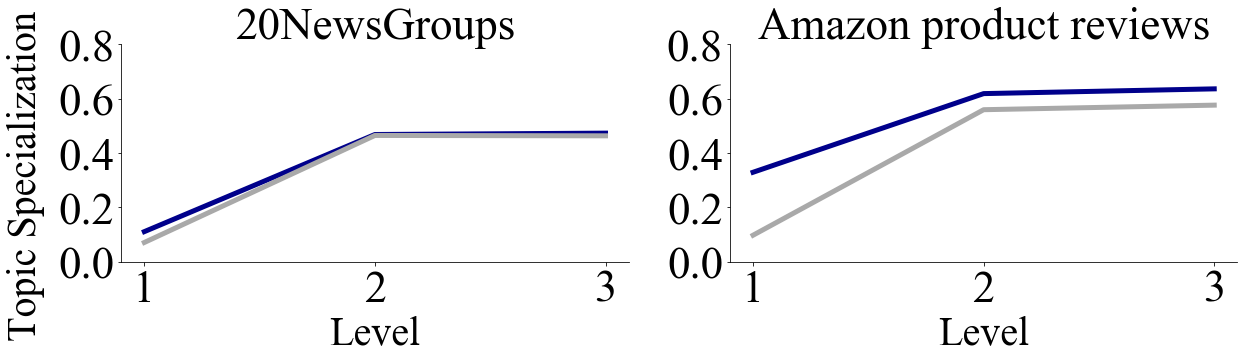

In [544]:
domain_title = {'bags': 'Amazon product reviews', '20news': '20NewsGroups'}
fig, (axl, axr) = plt.subplots(ncols=2, figsize=(20, 4))

def plot_topic_specialization(ax, domain, depth_specs_hntm, depth_specs_ncrp, ylabel=True):
    fontsize=45
    pd.DataFrame([depth_specs_hntm, depth_specs_ncrp], index=['TSNTM', 'nCRP']).T.plot(ax=ax, xticks=[1, 2, 3], yticks=[0.2*i for i in range(5)], fontsize=fontsize, color=['darkblue', 'darkgray'], legend=False, linewidth = 5.)
    ax.set_title(domain_title[domain], fontsize=fontsize)
    ax.set_xlabel('Level', fontsize=40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylabel: ax.set_ylabel('Topic Specialization', fontsize=40)
    ax.yaxis.set_label_coords(-0.15, 0.4)
    ax.patch.set_alpha(0)

plot_topic_specialization(axl, '20news', depth_specs_20news_hntm, depth_specs_20news_ncrp)
plot_topic_specialization(axr, 'bags', depth_specs_bags_hntm, depth_specs_bags_ncrp, ylabel=False)
fig.patch.set_alpha(0)
plt.savefig('fig/spec.pdf', bbox_inches="tight", pad_inches=0.0)

## hierarchical affinity

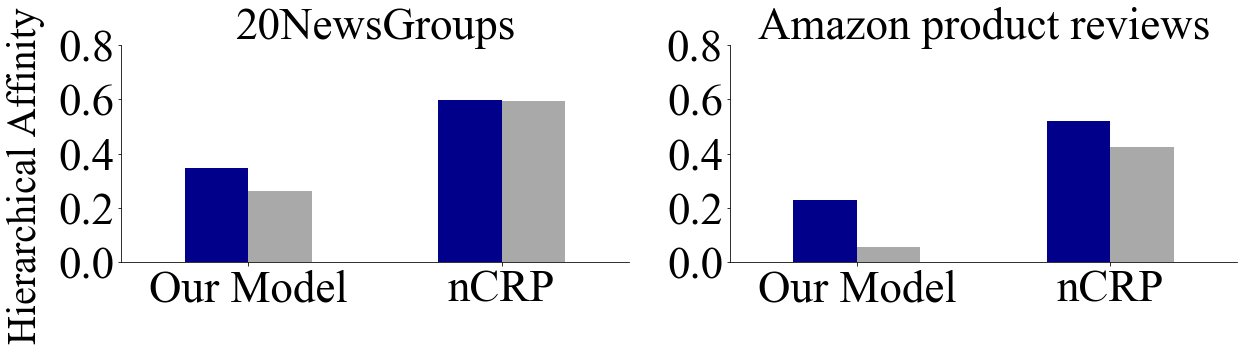

In [553]:
domain_title = {'bags': 'Amazon product reviews', '20news': '20NewsGroups'}
fig, (axl, axr) = plt.subplots(ncols=2, figsize=(20, 4))

def plot_topic_specialization(ax, domain, hierarchical_affinities_hntm, hierarchical_affinities_ncrp, ylabel=True):
    fontsize=45
    pd.DataFrame([hierarchical_affinities_hntm, hierarchical_affinities_ncrp], index=['Our Model', 'nCRP'], columns=['Child', 'Non-Child']).plot.bar(ax=ax, yticks=[0.2*i for i in range(5)], fontsize=fontsize, color=['darkblue', 'darkgray'], legend=False)
    ax.set_title(domain_title[domain], fontsize=fontsize)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=0, fontsize=fontsize);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylabel: ax.set_ylabel('Hierarchical Affinity', fontsize=40)
    ax.yaxis.set_label_coords(-0.15, 0.4)
    ax.patch.set_alpha(0)

plot_topic_specialization(axl, '20news', hierarchical_affinities_20news_hntm, hierarchical_affinities_20news_ncrp)
plot_topic_specialization(axr, 'bags', hierarchical_affinities_bags_hntm, hierarchical_affinities_bags_ncrp, ylabel=False)
fig.patch.set_alpha(0)
plt.savefig('fig/hier.pdf', bbox_inches="tight", pad_inches=0.0)

# scalability

In [161]:
pd.set_option('display.max_rows', 500)

In [469]:
def get_log_bags(model, size, threshold, nb_name=None):
    def get_steadys(df, threshold):
        steadys = []
        old_ppl = np.inf
        steady = 0
        for i, row in df.iterrows():
            new_ppl = row[:, 'PPL'].iloc[1]
            if steady < threshold:
                if new_ppl < old_ppl:
                    steady = 0
                    old_ppl = new_ppl
                else:
                    steady += 1
                steadys.append(steady)
            else:
                steadys.append(0)
        return steadys
    
    def get_cumtimes(df):
        cumtimes = []
        cumtime = 0
        for i, row in df.iterrows():
            time = row[:, 'Time'].iloc[0]
            cumtime += time
            cumtimes.append(cumtime)
        return cumtimes
    
    def get_time(df, threshold):
        for i, row in df.iterrows():
            steady = row[:, 'Steady'].iloc[0]
            if steady == threshold:  
                cumtime = row[:, 'Cumtime'].iloc[0]
                return cumtime
        return None    
    
    if model == 'hntm':
#         if nb_name is None: nb_name = '0 bags -tree 33 -seed 0 -size %i' % size
        if nb_name is None: nb_name = '0 bags -tree 33 -seed 1234 -size %i' % size
        config_bags_scale = load_config(config=config_bags, name_model = model, nb_name = nb_name, index=-1)
    elif model == 'ncrp':
#         if nb_name is None: nb_name = '0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 100 -size %i' % size
        if nb_name is None: nb_name = '0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 100 -size %i -seed 1000' % size
        config_bags_scale = load_config(config=config_bags, name_model = model, nb_name = nb_name, index=-1)
    log_bags = cPickle.load(open(config_bags_scale.path_log, 'rb'))
    log_bags['', 'Steady'] = get_steadys(log_bags, threshold)
    log_bags['', 'Cumtime'] = get_cumtimes(log_bags)
    time_bags = get_time(log_bags, threshold)
    return log_bags, time_bags

In [566]:
threshold = 10
log_bags = defaultdict(dict)
time_bags = defaultdict(dict)

In [567]:
log_bags['Our Model'][1000], time_bags['Our Model'][1000] = get_log_bags(model='hntm', size=1000, threshold=threshold)
log_bags['Our Model'][2000], time_bags['Our Model'][2000] = get_log_bags(model='hntm', size=2000, threshold=threshold)
log_bags['Our Model'][4000], time_bags['Our Model'][4000] = get_log_bags(model='hntm', size=4000, threshold=threshold)
log_bags['Our Model'][8000], time_bags['Our Model'][8000] = get_log_bags(model='hntm', size=8000, threshold=threshold)
log_bags['Our Model'][16000], time_bags['Our Model'][16000] = get_log_bags(model='hntm', size=16000, threshold=threshold)
log_bags['Our Model'][32000], time_bags['Our Model'][32000] = get_log_bags(model='hntm', size=32000, threshold=threshold)
# log_bags['Our Model'][16000], time_bags['Our Model'][16000] = get_log_bags(model='hntm', size=16000, threshold=threshold, nb_name='6 bags -tree 33 -seed 1234 -size 16000')
# log_bags['Our Model'][32000], time_bags['Our Model'][32000] = get_log_bags(model='hntm', size=32000, threshold=threshold, nb_name='6 bags -tree 33 -seed 1234 -size 32000')

/home/m-isonuma/.pyenv/versions/anaconda2-5.3.0/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/m-isonuma/.pyenv/versions/anaconda2-5.3.0/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [568]:
log_bags['nCRP'][1000], time_bags['nCRP'][1000] = get_log_bags(model='ncrp', size=1000, threshold=threshold)
log_bags['nCRP'][2000], time_bags['nCRP'][2000] = get_log_bags(model='ncrp', size=2000, threshold=threshold)
log_bags['nCRP'][4000], time_bags['nCRP'][4000] = get_log_bags(model='ncrp', size=4000, threshold=threshold)
log_bags['nCRP'][8000], time_bags['nCRP'][8000] = get_log_bags(model='ncrp', size=8000, threshold=threshold)
log_bags['nCRP'][16000], time_bags['nCRP'][16000] = get_log_bags(model='ncrp', size=16000, threshold=threshold)
log_bags['nCRP'][32000], time_bags['nCRP'][32000] = get_log_bags(model='ncrp', size=32000, threshold=threshold)
# log_bags['nCRP'][16000], time_bags['nCRP'][16000] = get_log_bags(model='ncrp', size=16000, threshold=threshold, nb_name='0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 100 -size 16000 -seed 1234') 
# log_bags['nCRP'][32000], time_bags['nCRP'][32000] = get_log_bags(model='ncrp', size=32000, threshold=threshold, nb_name='0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 100 -size 32000 -seed 1234')

## print

In [569]:
time_bags

defaultdict(dict,
            {'Our Model': {1000: 4.955980062484741,
              2000: 9.627694845199585,
              4000: 31.578554153442383,
              8000: 79.74887228012085,
              16000: 169.89345145225525,
              32000: 334.272878408432},
             'nCRP': {1000: 34.02160716056824,
              2000: 98.26564264297485,
              4000: 458.1820411682129,
              8000: 1051.2630937099457,
              16000: 2038.779834985733,
              32000: 4864.562474966049}})

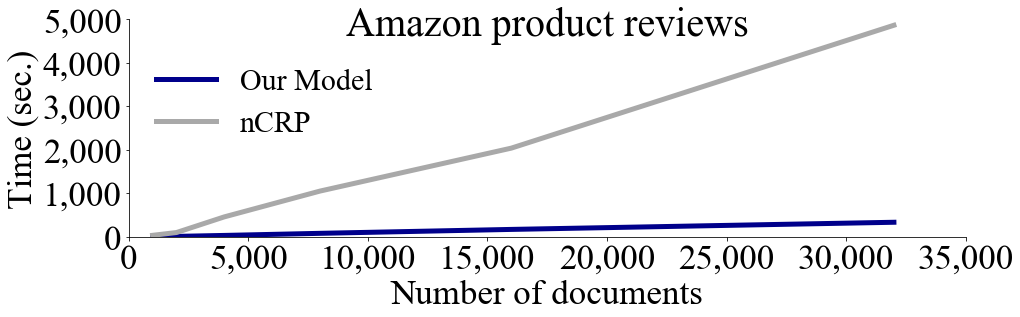

In [570]:
fontsize = 35
pd.DataFrame(time_bags).plot(fontsize=fontsize, color=['darkblue', 'darkgray'], legend=True, figsize=(15, 4), linewidth = 5.)
plt.title('Amazon product reviews', fontsize=40, pad=-16.0)
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=30, frameon=False)
plt.xlim(0, 35000)
plt.ylim(0, 5000)
plt.xticks(plt.xticks()[0], ['{:,}'.format(int(x)) for x in plt.xticks()[0]], rotation=0)
plt.yticks(plt.yticks()[0], ['{:,}'.format(int(x)) for x in plt.yticks()[0]])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Number of documents', fontsize=fontsize)
plt.ylabel('Time (sec.)', fontsize=fontsize)
fig.patch.set_alpha(0)
plt.savefig('fig/scale.pdf', bbox_inches="tight", pad_inches=0.0, transparent=True);